In [1]:
from autoformer.model import Autoformer
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping               
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,  PowerTransformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-10-05 22:37:22.960229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759691242.977127   23706 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759691242.982232   23706 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759691242.995386   23706 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759691242.995408   23706 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759691242.995410   23706 computation_placer.cc:177] computation placer alr

In [2]:
def create_sequences(X, y, window_size):
    seq_X = []
    seq_y = []
    for i in range(len(X) - window_size):
        seq_X.append(X[i:i+window_size])
        seq_y.append(y[i+window_size])

    return np.array(seq_X), np.array(seq_y)

def create_time_windows(data, target, window_size, horizon=1):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size - horizon + 1):
        X_windows.append(data[i:i+window_size])  # این باید یک sequence باشد
        y_windows.append(target[i+window_size:i+window_size+horizon])
    return np.array(X_windows), np.array(y_windows)

In [3]:
df= pd.read_csv('data/Tetuan City power consumption.csv')
# split data
X= df.drop(columns= ['Zone 3  Power Consumption'])
y= df[['Zone 3  Power Consumption']]

# create timestamp
X['DateTime'] = pd.to_datetime(X['DateTime'])
X['timestamp'] = X['DateTime'].astype('int')
X = X.set_index(['DateTime'])

# normalizing data
scaler = PowerTransformer(method='box-cox')
X['normed_general diffuse flows'] = scaler.fit_transform(X[['general diffuse flows']])
X['normed_diffuse flows'] = scaler.fit_transform(X[['diffuse flows']])
X['normed_humidity'] = np.clip(X['Humidity'], a_min=40, a_max=90)
X = X.drop(['Humidity', 'general diffuse flows', 'diffuse flows'], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

window_size = 144  # last 24 hour
horizon = 144  # forecast next hour

X_windows, y_windows = create_time_windows(X_scaled, y_scaled, window_size, horizon)

if len(y_windows.shape) == 1:
    y_windows = y_windows.reshape(-1, 1)

In [4]:
x_train, x_test, y_train, y_test= train_test_split(X_windows, y_windows, train_size=0.8, shuffle=False)
x_valid, x_test, y_valid, y_test= train_test_split(x_test, y_test, train_size=0.5, shuffle=False)

In [5]:
input_shape = (window_size, X.shape[1])
inputs= layers.Input(shape=input_shape)
x= Autoformer(d_out= 1,
            d_model= 16,
            n_heads= 4,
            conv_filter= 16,
            num_decoder=1,
            num_encoder=1)(inputs)

model= Model(inputs= inputs, outputs= x)      
model.compile(optimizer='adam', 
              loss=['mse'],
              metrics= ['RootMeanSquaredError'])
model.summary()  

I0000 00:00:1759691246.504405   23706 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2944 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 144, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autoformer (Autoformer)         │ (None, 144, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
callback= EarlyStopping(monitor='val_loss',
                        patience=20,
                        restore_best_weights= True)
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    shuffle=False,
    epochs=50,
    callbacks= callback
)

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead


I0000 00:00:1759691253.774710   23749 service.cc:152] XLA service 0x7f8264002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759691253.774729   23749 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-10-05 22:37:33.995175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759691254.938014   23749 cuda_dnn.cc:529] Loaded cuDNN version 90701


   8/1304 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - RootMeanSquaredError: 0.3067 - loss: 0.0941 

I0000 00:00:1759691262.206704   23749 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - RootMeanSquaredError: 0.1345 - loss: 0.0195 - val_RootMeanSquaredError: 0.0549 - val_loss: 0.0030
Epoch 2/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - RootMeanSquaredError: 0.0601 - loss: 0.0037 - val_RootMeanSquaredError: 0.0540 - val_loss: 0.0029
Epoch 3/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - RootMeanSquaredError: 0.0552 - loss: 0.0031 - val_RootMeanSquaredError: 0.0533 - val_loss: 0.0028
Epoch 4/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - RootMeanSquaredError: 0.0533 - loss: 0.0029 - val_RootMeanSquaredError: 0.0533 - val_loss: 0.0028
Epoch 5/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - RootMeanSquaredError: 0.0522 - loss: 0.0028 - val_RootMeanSquaredError: 0.0533 - val_loss: 0.0028
Epoch 6/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - RootMeanSquaredError: 0.0514 - loss: 0.0027 - val_RootMeanSquaredError: 0.0532 - val_loss: 0.0028
Epoch 7/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - RootMeanSquaredEr

In [7]:
# Evaluate the model accuracy on the validation set.
score = model.evaluate(x_test, y_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 0.0638 - loss: 0.0041


In [8]:
y_pred= model.predict(x_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step


In [9]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_true_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

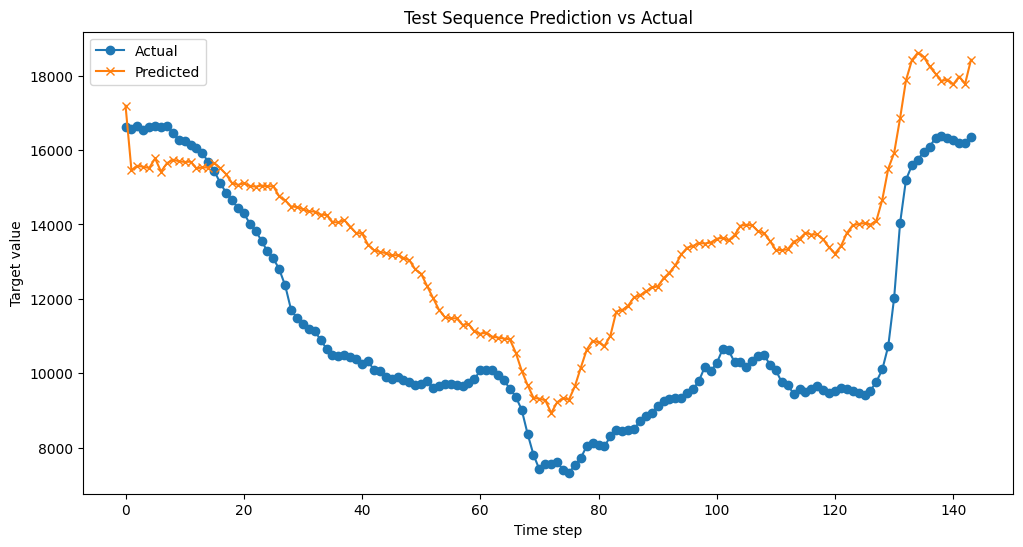

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_true_rescaled[0], label="Actual", marker='o')
plt.plot(y_pred_rescaled[0], label="Predicted", marker='x')
plt.title("Test Sequence Prediction vs Actual")
plt.xlabel("Time step")
plt.ylabel("Target value")
plt.legend()
plt.show()

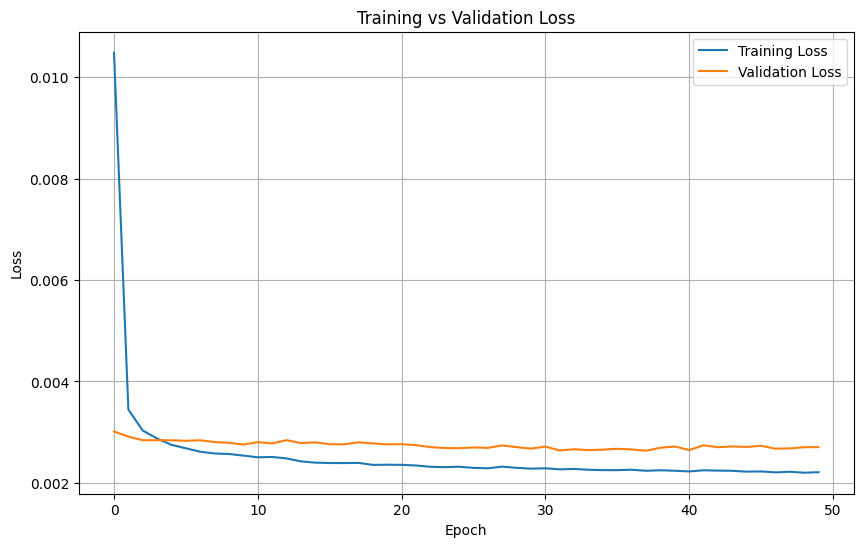

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()